# Analysis prompt 1

"What factors best predict whether an individual is categorized as in permanent housing or not in permanent housing"?


## Purpose

The purpose of this notebook is to give an indication about which factors contribute to a succesful leave out of homelessness. 

### Requirements

A DataFrame will be created that contains several attributes about an individual. 
This means that the DataFrame is aggregated at the individual level.

- Author: Annalie Kruseman
- Date: 2016-10-31

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %load_ext autoreload
# # the "1" means: always reload modules marked with "%aimport"
# %autoreload 1

from __future__ import absolute_import, division, print_function
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
# from tqdm import tqdm
# import warnings

sns.set_context("poster", font_scale=1.0)

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [3]:
# where the data is stored

matt = 'SampleDataSet-MOSBE&SCz-2012-1001--2016-0531/USE THIS ONE/'
annalie = 'data/c4sf/DATA_CTA/'

datadir = os.path.join(os.getenv('HOME'), annalie)

In [4]:
def encode_boolean(df, col):
    '''Encode values as booleans.
    If the string is 'Yes', the new value will be True. Otherwise it will be False.
    '''
    df.loc[df[col] == 'Yes', col] = True
    df.loc[df[col] == 'No', col] = False
    df.loc[df[col] == 'Not Applicable - Child', col] = False
    df.loc[df[col].isin(['Client refused',
                         "Client doesn't know",
                         'Data not collected',
                         '',
                         np.nan]), col] = False
    return df

In [5]:
def encode_unknown(df, col):
    '''Change non-informative values to 'Unknown'.
    '''
    df.loc[df[col].isin(['Client refused',
                         'Refused',
                         "Client doesn't know",
                         'Data not collected']), col] = 'Unknown'
    return df

In [6]:
sheet = 'Client'

cols = [
    'Personal ID',
    'Race',
    'Ethnicity',
    'Gender',
    'Veteran Status',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_client = pd.read_csv(infile, header=0, index_col=0, usecols=cols, sep=';')
df_client = df_client.dropna(how='all')
df_client.index = df_client.index.astype('int')

# drop people that we don't have demographic information for
df_client = df_client.dropna(how='any', subset=['Race', 'Ethnicity', 'Gender'])

# fill in missing values
df_client['Veteran Status'] = df_client['Veteran Status'].fillna(value='')

# Remove "(HUD) from strings
cols = ['Race', 'Ethnicity', 'Veteran Status']
for col in cols:
    df_client[col] = df_client[col].apply(lambda x: x.replace(' (HUD)', ''))

# put the nans back
df_client.loc[df_client['Veteran Status'] == '', 'Veteran Status'] = np.nan

# and encode booleans
df_client = encode_boolean(df_client, 'Veteran Status')

# Some are unknown
df_client = encode_unknown(df_client, 'Race')
df_client = encode_unknown(df_client, 'Ethnicity')
df_client = encode_unknown(df_client, 'Gender')

In [7]:
sheet = 'Enrollment'

cols = [
    'Personal ID',
    'Project Entry ID',
    'Client Age at Entry',
    'Last Permanent Zip',
    'Entry Date',
    'Exit Date',
    'Project ID',
    'Housing Status @ Project Start',
    'Living situation before program entry?',
    'Client Location',
    'Household ID',
    'Relationship to HoH',
    'Disabling Condition',
    'Continuously Homeless One Year',
    'Times Homeless Past Three Years',
    'Months Homeless This Time',
    'Chronic Homeless',
    'In Permanent Housing',
    'Residential Move In Date',
    'Domestic Violence Victim',
    'DV When Occurred',
    'DV Currently Fleeing',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_enroll = pd.read_csv(infile, header=0, index_col=0, usecols=cols, sep=';',
                        parse_dates=['Entry Date', 'Exit Date', 'Residential Move In Date'],
                        infer_datetime_format=True)

df_enroll = df_enroll.dropna(axis=0, how='all')
df_enroll.index = df_enroll.index.astype('int')

# drop anyone for whom we don't have age
df_enroll = df_enroll.dropna(subset=['Client Age at Entry'])

# turn these into integers
cols = ['Project Entry ID', 'Client Age at Entry', 'Project ID', 'Household ID']
for col in cols:
    df_enroll[col] = df_enroll[col].astype('int')

# Remove "(HUD) from strings
cols = ['Housing Status @ Project Start',
        'Living situation before program entry?',
        'Disabling Condition',
        'Continuously Homeless One Year',
        'Domestic Violence Victim',
        'DV When Occurred',
        'DV Currently Fleeing',
        ]
for col in cols:
    df_enroll[col] = df_enroll[col].fillna(value='')
    df_enroll[col] = df_enroll[col].apply(lambda x: x.replace(' (HUD)', ''))
    # put the nans back
    df_enroll.loc[df_enroll[col] == '', col] = np.nan

# encode booleans

# cols = [
#     'Disabling Condition',
#     'Continuously Homeless One Year',
#     'Chronic Homeless',
#     'In Permanent Housing',
#     'Domestic Violence Victim',
#     'DV Currently Fleeing', ]

col = 'Disabling Condition'
df_enroll = encode_boolean(df_enroll, col)

col = 'Continuously Homeless One Year'
df_enroll = encode_boolean(df_enroll, col)

col = 'Chronic Homeless'
df_enroll = encode_boolean(df_enroll, col)

col = 'In Permanent Housing'
df_enroll = encode_boolean(df_enroll, col)

col = 'Domestic Violence Victim'
df_enroll = encode_boolean(df_enroll, col)

col = 'DV Currently Fleeing'
df_enroll = encode_boolean(df_enroll, col)

In [8]:
# one person has a negative age. make it positive.
col = 'Client Age at Entry'
df_enroll.loc[df_enroll[col] < 0, col] = df_enroll.loc[df_enroll[col] < 0, col] * -1

In [9]:
sheet = 'Disability'

cols = [
    'Personal ID',
    'Disability Type',
    'Receiving Services For',
    'Disabilities ID',
    'Project Entry ID',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_disability = pd.read_csv(infile, header=0, index_col=0, usecols=cols, sep=',')
df_disability = df_disability.dropna(axis=0, how='all')
# df_disability.index = df_disability.index.astype('int') # TypeError: Setting dtype to anything other than float64 or object is not supported

# turn these into integers
cols = ['Disabilities ID', 'Project Entry ID']
for col in cols:
    df_disability[col] = df_disability[col].astype('int')

# Remove "(HUD) from strings
cols = ['Disability Type',
        'Receiving Services For',
        ]
for col in cols:
    df_disability[col] = df_disability[col].fillna(value='')
    df_disability[col] = df_disability[col].apply(lambda x: x.replace(' (HUD)', ''))
    # put the nans back
    df_disability.loc[df_disability[col] == '', col] = np.nan

# encode booleans
col = 'Receiving Services For'
df_disability = encode_boolean(df_disability, col)

In [10]:
sheet = 'HealthInsurance'

cols = [
    'Personal ID',
    'Health Insurance Information Date',
    'Health Insurance',
    'Data Collection Stage',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_healthins = pd.read_csv(infile, header=0, index_col=0, usecols=cols,
                           parse_dates=['Health Insurance Information Date'],
                           infer_datetime_format=True)

df_healthins = df_healthins.dropna(axis=0, how='all')
# df_healthins.index = df_healthins.index.astype('int')

In [11]:
sheet = 'Benefit'

cols = [
    'Personal ID',
    'Non-Cash Benefit',
    'Data Collection Stage',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_benefit = pd.read_csv(infile, header=0, index_col=0, usecols=cols, sep=';')

df_benefit = df_benefit.dropna(axis=0, how='all')
df_benefit.index = df_benefit.index.astype('int')

# Drop any project missing the code
df_benefit = df_benefit.dropna(how='any', subset=['Non-Cash Benefit'])

# Remove "(HUD) from strings
cols = ['Non-Cash Benefit',
        ]
for col in cols:
    df_benefit[col] = df_benefit[col].fillna(value='')
    df_benefit[col] = df_benefit[col].apply(lambda x: x.replace(' (HUD)', ''))
    # put the nans back
    df_benefit.loc[df_benefit[col] == '', col] = np.nan

# shorten some column values
col = 'Non-Cash Benefit'
df_benefit.loc[df_benefit[col] == 'Supplemental Nutrition Assistance Program (Food Stamps)', col] = 'Food Stamps'
df_benefit.loc[df_benefit[col] == 'Special Supplemental Nutrition Program for WIC', col] = 'WIC'
df_benefit.loc[df_benefit[col] == 'Section 8, Public Housing, or other ongoing rental assistance', col] = 'Section 8, Public Housing'

In [12]:
sheet = 'Income Entry & Exit'

cols = [
    'Personal ID',
    'Project Entry ID',
    'Entry Alimony',
    'Entry Child Support',
    'Entry Earned',
    'Entry GA',
    'Entry Other',
    'Entry Pension',
    'Entry Private Disability',
    'Entry Social Security Retirement',
    'Entry SSDI',
    'Entry SSI',
    'Entry TANF',
    'Entry Unemployment',
    'Entry VA Non-Service',
    'Entry VA Service Connected',
    "Entry Worker's Compensation",
    'Entry Total Income',
    'Exit Alimony',
    'Exit Child Support',
    'Exit Earned',
    'Exit GA',
    'Exit Other',
    'Exit Pension',
    'Exit Private Disability',
    'Exit Social Security Retirement',
    'Exit SSDI',
    'Exit SSI',
    'Exit TANF',
    'Exit Unemployment',
    'Exit VA Non-Service',
    'Exit VA Service Connected',
    "Exit Worker's Compensation",
    'Exit Total Income',
    'Income Change',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_income = pd.read_csv(infile, header=0, index_col=0, usecols=cols)

df_income = df_income.dropna(axis=0, how='all')
# df_income.index = df_income.index.astype('int')

# turn these into integers
cols = ['Project Entry ID']
for col in cols:
    df_income[col] = df_income[col].astype('int')

# assume all nans are $0
df_income = df_income.fillna(value='0')

# turn the dollar strings into integers
for col in df_income.columns:
    if col != 'Project Entry ID':
        df_income[col] = df_income[col].str.replace(',', '')
        df_income[col] = df_income[col].str.replace(r'[^-+\d.]', '').astype(int)

In [13]:
sheet = 'Service'

cols =  [
    'Personal ID',
    'Services ID',
    'Date Provided',
    'Date Ended',
    'Service Code',
    'Description',
    'Project ID',
    'Record Type',
    'Project Entry ID',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_service = pd.read_csv(infile, header=0, index_col=0, usecols=cols, sep=';',
                         parse_dates=['Date Provided', 'Date Ended'],
                         infer_datetime_format=True)

df_service = df_service.dropna(axis=0, how='all')
df_service.index = df_service.index.astype('int')

# Drop anyone missing these IDs
df_service = df_service.dropna(how='any', subset=['Project ID', 'Project Entry ID'])

# turn these into integers
cols = ['Project ID', 'Project Entry ID']
for col in cols:
    df_service[col] = df_service[col].astype('int')

In [14]:
# drop any null dates
df_service = df_service.dropna(subset=['Date Provided', 'Date Ended'])

In [15]:
sheet = 'Project'

cols = [
    'Project ID',
    'Project Name',
    'Project Type Code',
    'Address City',
    'Organization Name',
    'Address Postal Code'
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_project = pd.read_csv(infile, header=0, index_col=1, usecols=cols, sep=';')

df_project.head()

df_project = df_project.dropna(axis=0, how='all')
df_project.index = df_project.index.astype('int')

# Drop any project missing the code
df_project = df_project.dropna(how='any', subset=['Project Type Code'])

# Remove "(HUD) from strings
cols = ['Project Type Code',
        ]
for col in cols:
    df_project[col] = df_project[col].fillna(value='')
    df_project[col] = df_project[col].apply(lambda x: x.replace(' (HUD)', ''))
    # put the nans back
    df_project.loc[df_project[col] == '', col] = np.nan

In [16]:
sheet = 'BedInventory'

cols = [
    'Project ID',
    'Inventory ID',
    'Inventory Household Type',
    'HMIS Participating Beds',
    'Inventory Start Date',
    'Inventory End Date',
    'Unit Inventory',
    'Bed Inventory',
    'Vet Bed Inventory',
    'Youth Bed Inventory',
    'Youth Bed Age Group',
    ]

infile = os.path.join(datadir, '{s}.csv'.format(s=sheet))

df_bedinv = pd.read_csv(infile, header=0, index_col=0, usecols=cols,
                        parse_dates=['Inventory Start Date', 'Inventory End Date'],
                        infer_datetime_format=True)

df_bedinv = df_bedinv.dropna(axis=0, how='all')
# df_bedinv.index = df_bedinv.index.astype('int')

# turn these into integers, assume zero if NaN
cols = ['Inventory ID', 'HMIS Participating Beds', 'Unit Inventory', 'Bed Inventory', 'Vet Bed Inventory', 'Youth Bed Inventory']
for col in cols:
    # df_bedinv[col] = df_bedinv.loc[~df_bedinv[col].isnull(), col].apply(lambda x: int(x))
    df_bedinv[col] = df_bedinv[col].fillna(value=0)
    df_bedinv[col] = df_bedinv[col].astype('int')

# Clean data and make some features

In [17]:
# Only keep rows with entry dates starting in 2011
df_enroll = df_enroll[df_enroll['Entry Date'] >= '2011']

# Only keep rows with exit date
df_enroll = df_enroll[df_enroll['Exit Date'].notnull()]

In [18]:
# calculate the number of days that someone was enrolled
df_enroll['Days Enrolled'] = ((df_enroll['Exit Date'] - df_enroll['Entry Date']) / np.timedelta64(1, 'D')).astype(int)

In [19]:
# remove anyone with negative number of enrollment days
df_enroll = df_enroll[df_enroll['Days Enrolled'] >= 0]

In [20]:
# Join the client information with enrollment information.
# Inner join because we need both.
df = df_client.merge(df_enroll, how='inner', left_index=True, right_index=True)

In [21]:
# Join the merged new dataframe with benefit information.
df = df.merge(df_benefit.reset_index().groupby(by=['Personal ID'])[['Non-Cash Benefit']].nth(0),
              how='left', left_index=True, right_index=True)

df['Non-Cash Benefit'] = df['Non-Cash Benefit'].fillna('None')

In [22]:
# Join the merged new dataframe with disability information.
df = df.merge(df_disability.reset_index().groupby(by=['Personal ID'])[['Disability Type']].nth(0),
              how='left', left_index=True, right_index=True)

df['Disability Type'] = df['Disability Type'].fillna('None')

In [23]:
# merge organizations from the project dataframe with the merged client and enrollment dataframe

# make column of index from df dataframe (Personal ID)
df_resetindex = df.reset_index()
# make column of index from project dataframe (Project ID)
df_project_resetindex = df_project.reset_index()

# merge new df dataframe with project dataframe on Project ID
df_dfProject = df_resetindex.merge(df_project_resetindex, how='left', on='Project ID').set_index('Personal ID').sort_index()

In [24]:
# when 'Days Enrolled' is 0 and 'Non-Cash Benefit' is foodstamp, rename 0 value to 1
df_dfProject.ix[(df_dfProject['Days Enrolled'] == 0) & (df_dfProject['Non-Cash Benefit'] == 'Food Stamps'), 'Days Enrolled'] = 1

In [25]:
df_dfProject['Non-Cash Benefit'].value_counts()

None                            39890
Food Stamps                     20938
Other Source                      992
Section 8, Public Housing         964
WIC                               611
Other TANF-Funded Services        183
TANF Transportation Services       42
TANF Child Care Services           33
Temporary rental assistance        13
dtype: int64

    NB: What does it mean that someone doesn't receive a 'Non-Cash Benefit' (value = None), but for example, is
    registered for Emergency Shelter?

In [26]:
# remove all 'None' values for 'Non-Cash Benefit'
df_dfProject = df_dfProject[df_dfProject['Non-Cash Benefit'] != 'None']

In [27]:
df = df_dfProject

In [28]:
# sort by entry date
df = df.sort('Entry Date')

In [29]:
# set up to count the number of times a person was in the system
df['Enrollments'] = 1

In [30]:
agg = {'In Permanent Housing': 'last',
       'Enrollments': 'sum',
       'Race': 'first',
       'Ethnicity': 'first',
       'Gender': 'first',
       'Veteran Status': 'max',
       'Client Age at Entry': 'last',
       'Days Enrolled': 'sum',
       'Domestic Violence Victim': 'max',
       'Disability Type': 'last',
       'Non-Cash Benefit': 'last',
       'Housing Status @ Project Start': 'last',
       'Living situation before program entry?': 'last',
       'Continuously Homeless One Year': 'max',
#        'Months Homeless This Time': 'last',
       'Chronic Homeless': 'max',
       'Project Name': 'last',
       'Organization Name': 'last',
       'Project Type Code': 'last',
#        'Address City': 'last',
#        'Address Postal Code': 'last',
      }
df_features = df.reset_index().groupby(by=['Personal ID']).agg(agg)

In [31]:
# replace values in the below columns to values where False = 0 and True = 1
df_features['In Permanent Housing'] = df_features['In Permanent Housing'].map({False: 0, True: 1})
df_features['Chronic Homeless'] = df_features['Chronic Homeless'].map({False: 0, True: 1})
df_features['Domestic Violence Victim'] = df_features['Domestic Violence Victim'].map({False: 0, True: 1})
df_features['Veteran Status'] = df_features['Veteran Status'].map({False: 0, True: 1})
df_features['Continuously Homeless One Year'] = df_features['Continuously Homeless One Year'].map({False: 0, True: 1})

In [32]:
# number of missing values in column 'Months Homeless This Time":
# df_features['Months Homeless This Time'].isnull().sum().sum()

In [33]:
# number of total values
len(df_features)

3397

    Remove values with missing values in the column "Months Homeless This Time"

In [34]:
# create dummy variables for the following variables
for column in ['Non-Cash Benefit', 'Housing Status @ Project Start', 'Gender', 'Disability Type', 'Living situation before program entry?', 'Race', 'Project Name', 'Organization Name', 'Project Type Code', 'Ethnicity']:
    dummies = pd.get_dummies(df_features[column])
    df_features[dummies.columns] = dummies

In [35]:
# create a new dataframe that contains only numeric datatypes
df_features_numeric = df_features.drop(['Non-Cash Benefit', 'Housing Status @ Project Start', 'Domestic Violence Victim', 'Gender', 'Disability Type',
                                        'Living situation before program entry?','Race', 'Project Name', 'Organization Name',
                                        'Project Type Code', 'Ethnicity'], axis=1)

In [36]:
df_features_numeric.head()

,Chronic Homeless,Veteran Status,Days Enrolled,In Permanent Housing,Client Age at Entry,Enrollments,Continuously Homeless One Year,Food Stamps,Other Source,Other TANF-Funded Services,"Section 8, Public Housing",TANF Child Care Services,TANF Transportation Services,Temporary rental assistance,WIC,At-risk of homelessness,Category 1 - Homeless,Category 2 - At imminent risk of losing housing,Category 3 - Homeless only under other federal statutes,Category 4 - Fleeing domestic violence,Client doesn't know,Client refused,Data not collected,Stably housed,Female,Male,Other,Transgender female to male,Transgender male to female,Unknown,Alcohol Abuse,Both Alcohol and Drug Abuse,Chronic Health Condition,Developmental,Drug Abuse,HIV/AIDS,Mental Health Problem,None,Physical,Substance Abuse,"Emergency shelter, including hotel or motel paid for with emergency shelter voucher(HUD)",Foster care home or foster care group home,Hospital or other residential non-psychiatric medical facility,Hotel or motel paid for without emergency shelter voucher,"Jail, prison or juvenile detention facility","Owned by client, no ongoing housing subsidy","Owned by client, with ongoing housing subsidy",Permanent housing for formerly homeless persons,Place not meant for habitation,Psychiatric hospital or other psychiatric facility,"Rental by client, no ongoing housing subsidy","Rental by client, with VASH subsidy","Rental by client, with other ongoing housing subsidy",Residential project or halfway house with no homeless criteria,Safe Haven,"Staying or living in a family member's room, apartment or house","Staying or living in a friend's room, apartment or house",Substance abuse treatment facility or detox center,Transitional housing for homeless persons (including homeless youth),American Indian or Alaska Native,Asian,Black or African American,Native Hawaiian or Other Pacific Islander,White,MOSBE SOP - Transitional Housing - Men In Transition,MOSBE - Homeless Winter Shelter for Families,MOSBE CHS - Elm House,MOSBE CHS - RHY - BCP - HP,MOSBE CHS - RHY SOP,MOSBE CHS - Safe Passage,MOSBE CHS - Safe Place Warming Shelter,MOSBE CSUMB - Chinatown Project,MOSBE Franciscan Workers - House of Peace,MOSBE Franciscan Workers - Women Alive! Shelter,MOSBE Franciscan Workers of Junipero Serra,MOSBE HRC - LEGACY Emergency Rental Assistance,MOSBE HRC - SSVF- P1 - CCCIL HP,MOSBE HRC - SSVF- P1 - CCCIL RRH,MOSBE HRC - SSVF- P1 - HRC HP,MOSBE HRC - SSVF- P1 - HRC RRH,MOSBE HRC - SSVF- P1 - VTC HP,MOSBE HRC - SSVF- P1 - VTC RRH,MOSBE HRC - SSVF- P2 HRC- RRH - Santa Cruz Clients,MOSBE HRC - SSVF- P2 - HRC RRH,MOSBE HRC - SSVF- P2 HRC - HP- Monterey/San Benito Clients,MOSBE HRC - SSVF- P2 HRC - RRH- Monterey/San Benito Clients,MOSBE HRC - Security Deposit Guarantees,MOSBE Housing Authority - Pueblo del Mar Family Recovery Community,MOSBE Housing Authority - S + C Vouchers,MOSBE Housing Resource Center (HRC)*,MOSBE Interim,MOSBE Interim - MCHOME Enrolled,MOSBE Interim - MCHOME Outreach,MOSBE Interim - MCHOME S+C,MOSBE Interim - MCHOPE,MOSBE Interim - Sandy Shores,MOSBE Interim - Shelter Cove,MOSBE Interim - Sunflower Gardens - PSH,MOSBE Interim - Sunflower Gardens - THU,MOSBE SOP - Hamilton ES,MOSBE SOP - Hamilton Family Units -DO NOT USE-,MOSBE SOP - MLP - Emergency Men's Program,MOSBE SOP - Mobile Outreach Shelter Program - MOST,MOSBE SOP - Natividad Shelter,MOSBE SOP - Transitional Housing - Lexington Court,MOSBE SOP - Transitional Housing - Wittenmyer (Homeward Bound),MOSBE SOP - Winter Warming Shelter,MOSBE San Benito County - Helping Hands,MOSBE San Benito County - Homeless Warming Shelter,MOSBE The Salvation Army - Casa de las Palmas,MOSBE The Salvation Army - Fredericksen House,MOSBE The Salvation Army - Good Samaritan Center,MOSBE The Salvation Army - Phase II,MOSBE VTC DO NOT ENTER HERE,MOSBE Veterans Transition Center - GPD Housing,MOSBE Veterans Transition Center - Outreach,SCz - CAB TSP Rental Assistance,SCz - County Office of Education,SCz - Encompass,SCz - Encompass - Ander

# Fit a logistic regression model

In [37]:
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [38]:
# create a feature set and target variable
predictors = df_features_numeric.drop(['In Permanent Housing'], axis=1)
targets = df_features_numeric['In Permanent Housing']

# # Or should I use a list as input?
# predictors_matrix = predictors.as_matrix()
# targets_list = targets.tolist()

In [39]:
# split data set in training and test set
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, targets, test_size=.3)

# pred_train, pred_test, tar_train, tar_test = train_test_split(predictors_matrix, targets_list, test_size=.3)

In [40]:
# show the shape of the train and test sets
print ("pred_train shape =", pred_train.shape)
print ("pred_test shape =", pred_test.shape)
print ("tar_train shape =", tar_train.shape)
print ("tar_test shape =", tar_test.shape)

pred_train shape = (2377, 199)
pred_test shape = (1020, 199)
tar_train shape = (2377,)
tar_test shape = (1020,)


In [41]:
# fit a logistic regression model to the data
lr_model = LogisticRegression()
lr_model.fit(pred_train, tar_train)
print(lr_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)


In [42]:
# make predictions
expected = tar_test
predicted = lr_model.predict(pred_test)

In [43]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print ("accuracy score:", sklearn.metrics.accuracy_score(expected, predicted))

             precision    recall  f1-score   support

          0       0.95      0.97      0.96       924
          1       0.66      0.52      0.58        96

avg / total       0.92      0.93      0.93      1020

[[898  26]
 [ 46  50]]
accuracy score: 0.929411764706


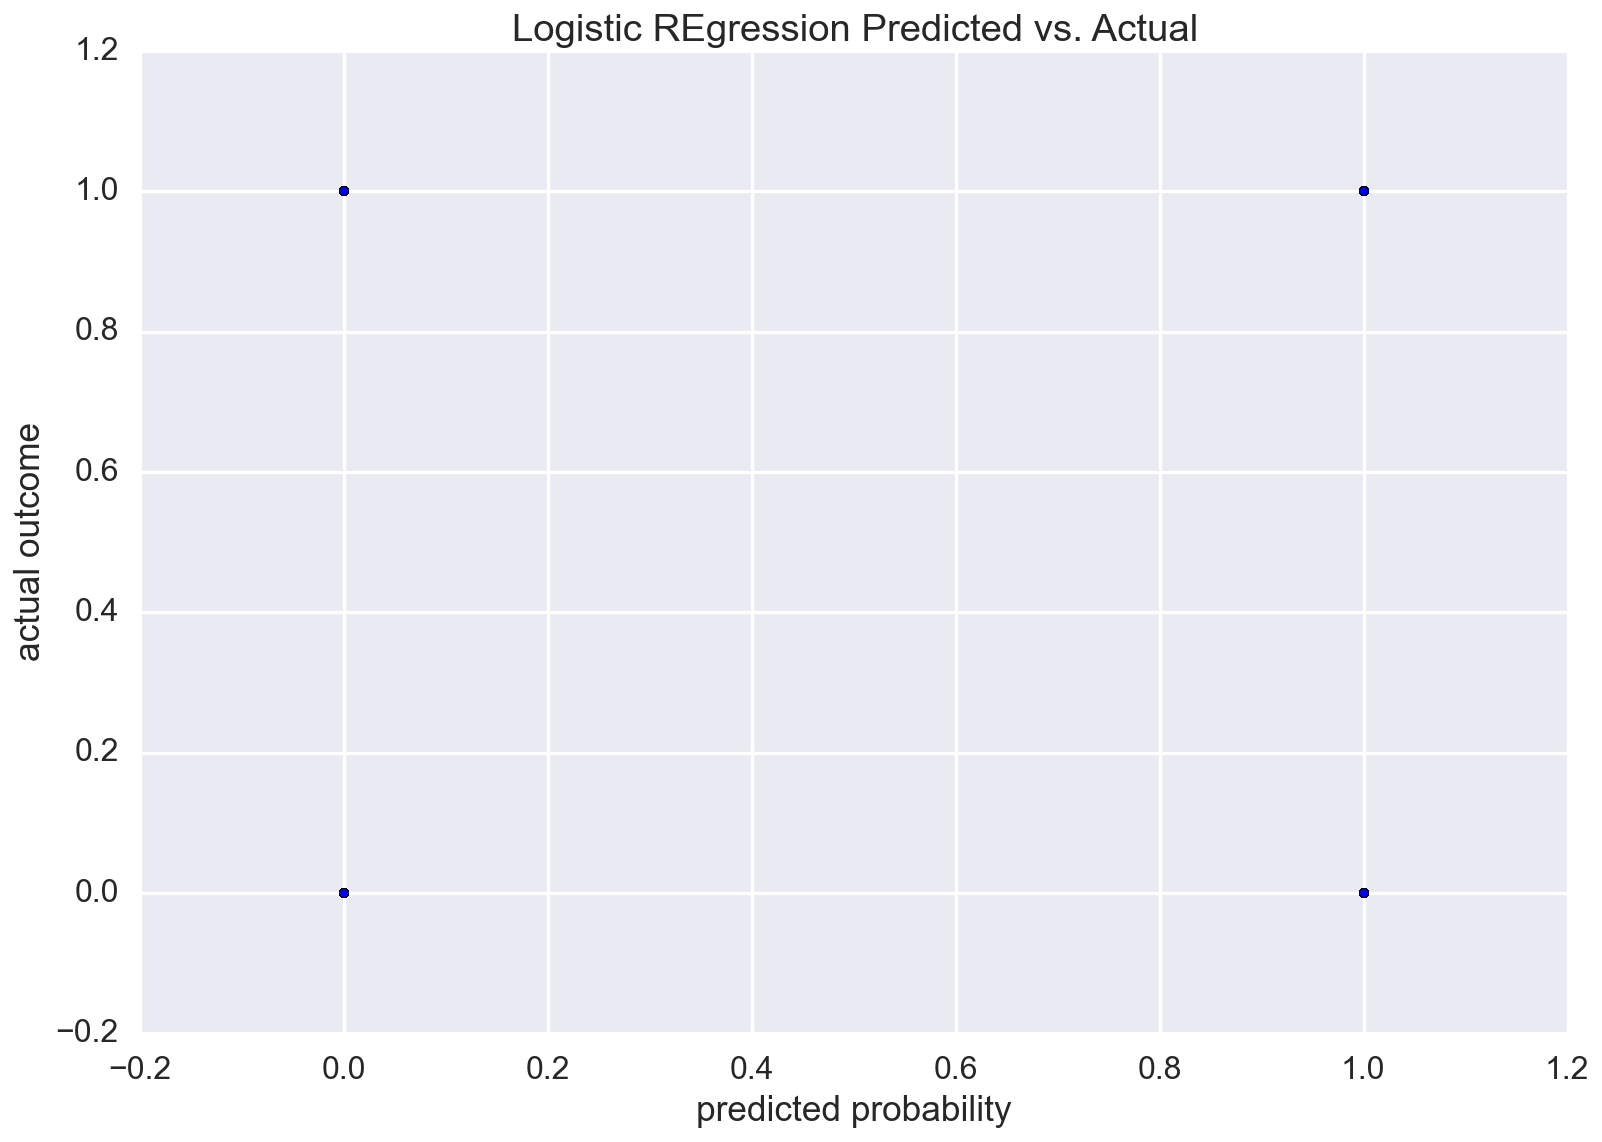

In [44]:
plt.scatter(predicted, expected)
plt.xlabel("predicted probability")
plt.ylabel("actual outcome")
plt.title("Logistic REgression Predicted vs. Actual")
plt.show()

In [45]:
# predict class probabilities of the input samples
predict_probability_lr = lr_model.predict_proba(pred_test)
# list(predict_probability_lr)

In [46]:
# list(predicted)

In [47]:
# get coefficient per predictor

# 1. create list of coefficients and predictors
coef = lr_model.coef_
coef = coef.tolist()
# unnest nested list
coef = sum(coef, [])

predictors_columns = list(predictors.columns)

In [48]:
def mean(x):
    return sum(x) / len(x)

# standard error (deviation from the mean)
def de_mean(x):
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

In [49]:
mean(de_mean(predictors['Chronic Homeless']))

2.0007382399172953e-16

In [50]:
st_error = []
for i in pred_test.columns:
    st_error.append(mean(de_mean(predictors[i])))

In [54]:
predictors_coef_sterror = zip(predictors_columns, coef, st_error)

In [52]:
predictors_coef_sterror_matrix = np.array(predictors_coef_sterror)
predictors_coef_sterror_matrix[1]

predictors_coef_sterror_matrix_T = predictors_coef_sterror_matrix.transpose()
predictors = predictors_coef_sterror_matrix_T[0]
coef = predictors_coef_sterror_matrix_T[1].astype(float)
st_error = predictors_coef_sterror_matrix_T[2].astype(float)

print (predictors[:5])
print (coef[:5])
print (st_error[:5])

['Chronic Homeless' 'Veteran Status' 'Days Enrolled' 'Client Age at Entry'
 'Enrollments']
[ -3.33667560e-01   1.20830711e+00   7.05540598e-04  -1.54002930e-02
   2.72601519e-03]
[  2.00073824e-16  -1.46384720e-15   3.21539308e-12  -3.44624731e-14
   5.73935300e-14]


In [53]:
import numpy as np
predictors_coef_sterror_matrix_T = predictors_coef_sterror_matrix.transpose()
z_score = np.divide(coef, st_error)
z_score[:5]

array([ -1.66772221e+15,  -8.25432540e+14,   2.19425924e+08,
         4.46871383e+11,   4.74969075e+10])

In [55]:
statistics = np.column_stack((predictors, coef, st_error, z_score))
statistics[0]

array(['Chronic Homeless', '-0.333667560031', '2.00073823992e-16',
       '-1.6677222106e+15'], 
      dtype='|S88')

In [60]:
# sort predictors by highest to lowest z-score
def getKey(item):
    return item[3]

statistics_sorted = sorted(statistics, key = getKey, reverse = True)

In [61]:
columns = ['predictor', 'coefficient', 'standard error', 'z-score']

output_lr = pd.DataFrame(data = statistics_sorted, columns = columns)
output_lr.head()

,predictor,coefficient,standard error,z-score
0,SCz - Salvation Army- Winter (Cold Weather) Sh...,-0.0598457412099,-6.13572255183e-17,9.75365830257e+14
1,SCz - Encompass - Anderson,-0.00925379135695,-9.8621863791e-20,9.38310330107e+16
2,Male,-0.537308855979,-5.75178540194e-16,9.34160123216e+14
3,Transitional housing,-1.30631058298,-1.43023329091e-15,9.1335489901e+14
4,PH - Rapid Re-Housing,1.82822913812,2.00422709208e-15,9.1218662064e+14


In [138]:
reduced_pred_train = lr_model.transform(pred_train)

# Further analysis

In [ ]:
# Is there a p-value that I could calculate for logistic regression?
# Or is there something similar to lasso regression for logistic regression?

# The organization names show high coefficients:
# Should we split the model into several models that represent a group of variables? 
    # e.g. organization name versus individual characteristics, etc.?

# Logistic regression with cross-validation

In [128]:
# cross_val_score automatically equals the size of the training and test set
from sklearn.cross_validation import cross_val_score

# perform 10-fold cross validation
lr_model_crossval = LogisticRegression()

scores = cross_val_score(lr_model_crossval, predictors, targets, cv = 10, scoring = 'accuracy')
print ('scores for all the 10 samples: ')
print (scores)
print ("---")
print ('mean score:')
print (scores.mean())

scores for all the 10 samples: 
[ 0.9         0.94705882  0.94117647  0.95        0.95294118  0.94117647
  0.94411765  0.92625369  0.8879056   0.92625369]
---
mean score:
0.931688356759
